In [1]:
import torch
import torch.nn as nn
import numpy as np
import random                                                                  
import matplotlib.pyplot as plt
torch.backends.cudnn.deterministic=True
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import math
from torch.autograd import grad
from Libraries import robotarm as ra
from Libraries import ICNN_net as net
from Libraries import ICNN_plot as pl
from Libraries import ICNN_optim_exp_barrier as opt
dtype = torch.float
device_c = torch.device("cpu")
device = torch.device("cuda:0")

In [2]:
#robot initialize
l1 = 3 
l2 = 2
m1 = 3
m2 = 4
robot = ra.robotarm(l1,l2,m1,m2,device)
xinit = torch.tensor([[-2],[2]],dtype=dtype)
#xinit = torch.tensor([[0],[3]],dtype=dtype)
xfinal = torch.tensor([[3],[3]],dtype=dtype)
#xinit = torch.tensor([[-3],[0]],dtype=dtype)
#xfinal = torch.tensor([[3],[2.5]],dtype=dtype)
T = 3
delta = 0.6
num_timesteps = 100
rmin,rmax,qmin,qmax,dt,qinit,qfinal,Xstable,xtraj,x_dot,qtraj,q_dot = robot.Initialize(xinit,xfinal,T,delta,num_timesteps)

#spline adopting

xpoints = np.array([   -2,  -3,  -1,  0 ,1,  2])
ypoints = np.array([   1 ,   2,   3,  2 ,3,  3])
xtraj,x_dot = robot.spline_traj(xpoints,ypoints, T, delta, num_timesteps)
qtraj = robot.config_trajectory(xtraj)
q_dot = robot.config_velocity(qtraj,x_dot)

#qtraj = qtraj[:,0:90]
#q_dot = q_dot[:,0:90]


#ICNN initialize
fhat_size = 500
V_size = 200
V_hidden_sizes = [V_size, V_size,V_size,V_size]
fhat_hidden_sizes = [fhat_size,fhat_size,fhat_size,fhat_size,fhat_size,fhat_size,fhat_size,fhat_size,fhat_size]
tol = 0.01
alpha = 0.01
#model = net.ICNN_net( V_hidden_sizes, fhat_hidden_sizes,tol,alpha)


In [3]:
###################################################################
#getting grid data (for the regularizer)
nq1 = 100 # grid number
nq2 = 100 
nq1_b = 10 # grid number
nq2_b = 10
penalty = 5000
penalty_boundary = 100000
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device) #qmin, qmax는 위에서 구함
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)
q_in_boundary,q_dot_boundary = optim_.get_boundary(nq1_b,nq2_b,qmin,qmax)

In [4]:
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=3000)

 epoch = 3000, loss = 0.07321904, loss_b = 0.17423429, loss_t = 0.042861454                    ....                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [7]:
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=1000,weight_decay = 1e-4)

 epoch = 1000, loss = 0.0005194472, loss_b = 0.0003614336, loss_t = 0.0005193166                    ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [5]:
optim_.optim_Kinematic_reg(robot, q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, Xstable, learning_rate = 4e-4,epoch=150, batch_size = 40)

 epoch = 1 i = 153, loss = 98671.69, total_loss = 99591.21, loss_b = 0.1466107, loss_t = 1.4877158, loss_reg = 472.14856, loss_reg_total =  665.2572           .   ...                                                                                                                                                                                                                                                                                                                                                                                                               

KeyboardInterrupt: 

In [6]:
nq1_p = 100
nq2_p = 100
nx1 = 100
nx2 = 100
xmin = [-robot.l1-robot.l2, -robot.l2]
xmax = [robot.l1+robot.l2,robot.l1+robot.l2]
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)

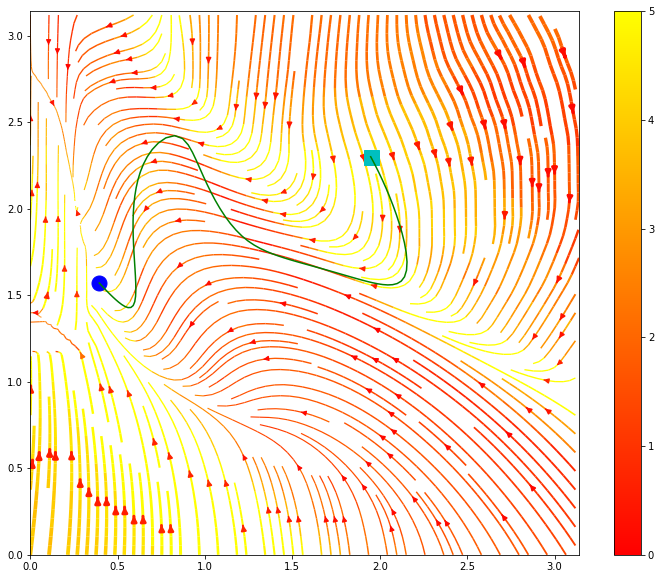

In [7]:
plt_.plot_f('fplot.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

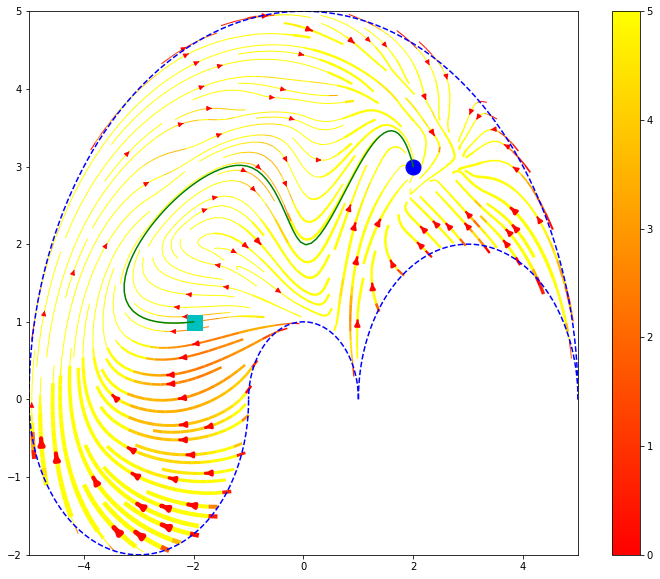

In [14]:
plt_.plot_f_taskspace('task_plot.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)

In [ ]:
plt_.plot_V